# Imports

In [5]:
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

from data_loader import MyDataLoader
from my_config import load_config, MyConfig

# Load (Preprocessed Step 1) DTU Solar Station data

In [6]:
from data_loader import SPLIT


PATH_TO_CONFIG = r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\configs\dni_only\PERSISTENCE_DNI_LAG_60.json'
my_config: MyConfig = load_config(PATH_TO_CONFIG)
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)
df = data_loader.get_split(SPLIT.TEST)

# mask = df.isna().values
# # make all nan values zero
# df.fillna(0, inplace=True)
display(df.head())

,DNI,DNI_lag_60
2024-01-01 07:43:00,0.0,0.0
2024-01-01 07:44:00,0.0,0.0
2024-01-01 07:45:00,0.0,0.0
2024-01-01 07:46:00,0.0,0.0
2024-01-01 07:47:00,0.0,0.0


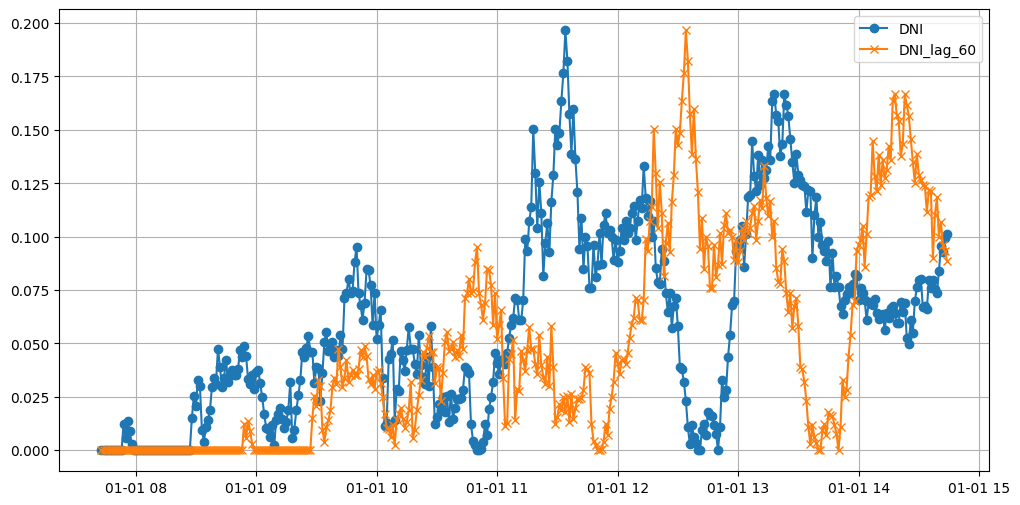

In [7]:
import matplotlib.pyplot as plt

# Select a subset of the data for plotting
subset = df.loc['2024-01-01']

# Plot the original and lagged values
plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset[data_loader.get_target_names()], label=', '.join(data_loader.get_target_names()), marker='o')
plt.plot(subset.index, subset[data_loader.get_feature_names()], label=', '.join(data_loader.get_feature_names()), marker='x')


plt.legend()
plt.grid()
plt.show()

In [8]:
import datetime
import shutil
from _config import PATH_CHECKPOINT
from data_loader import SPLIT

test_predictions_df = pd.DataFrame({
    my_config.name: df[data_loader.get_feature_names()[0]],
}, index=data_loader.get_split(SPLIT.TEST).index)

time_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S_{0}".format(my_config.name))
PATH_CHECKPOINT = PATH_CHECKPOINT / time_str
PATH_CHECKPOINT.mkdir(parents=True, exist_ok=True)
shutil.copy(PATH_TO_CONFIG, PATH_CHECKPOINT / 'config.json')  # copy config file to checkpoint directory
test_predictions_df.to_pickle(PATH_CHECKPOINT / 'predictions.pkl')
test_predictions_df

,PERSISTENCE_DNI_LAG_60
2024-01-01 07:43:00,0.0
2024-01-01 07:44:00,0.0
2024-01-01 07:45:00,0.0
2024-01-01 07:46:00,0.0
2024-01-01 07:47:00,0.0
...,...
2024-12-30 14:38:00,0.0
2024-12-30 14:39:00,0.0
2024-12-30 14:40:00,0.0
2024-12-30 14:41:00,0.0


# Persistence model

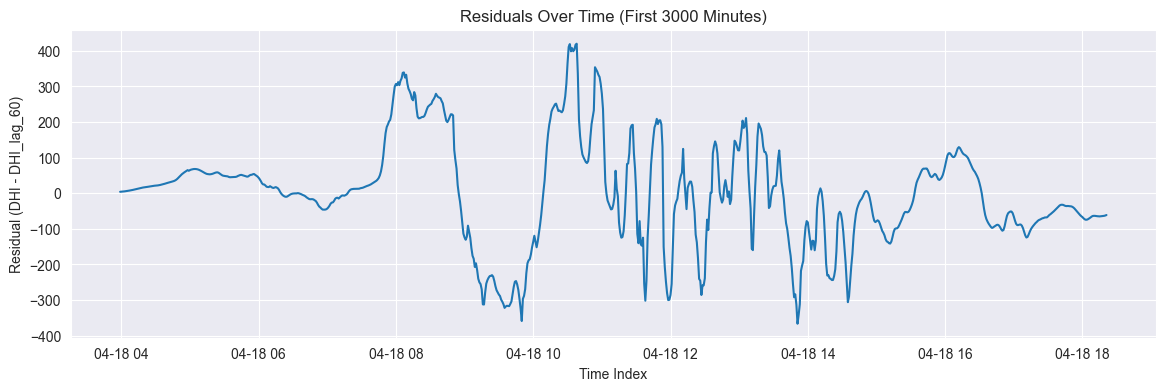

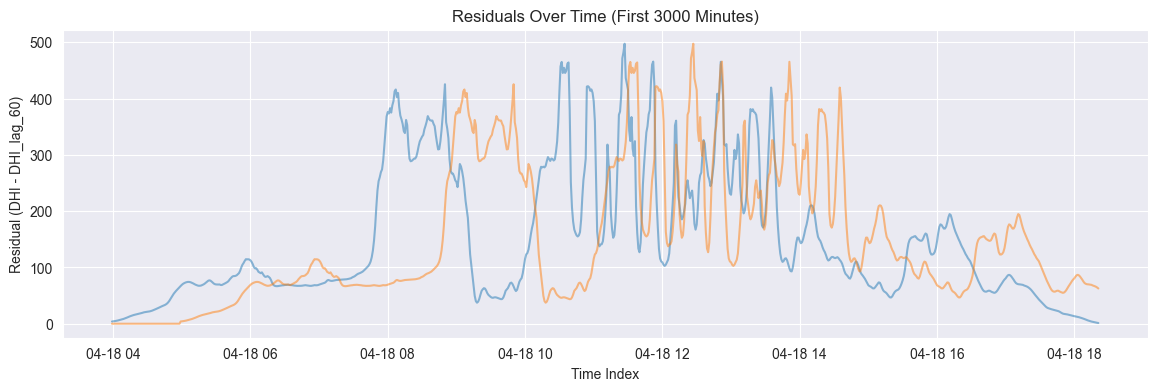

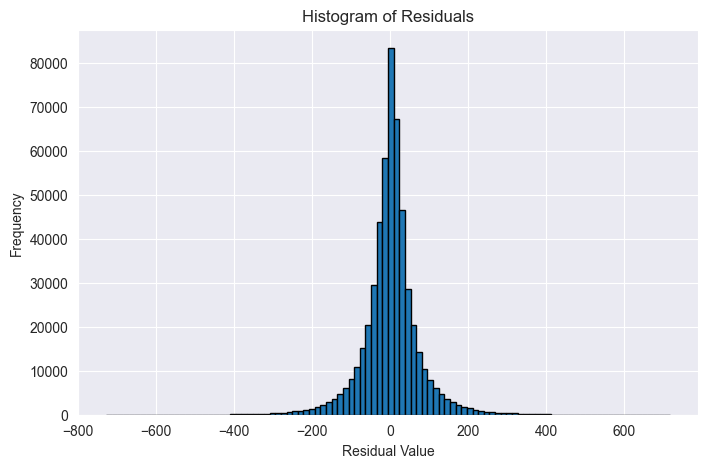

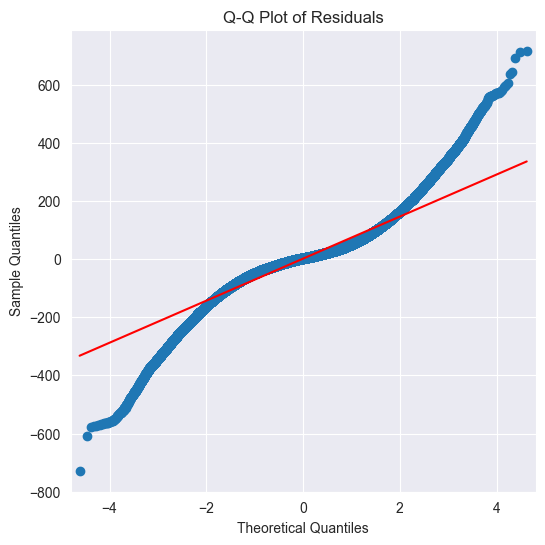

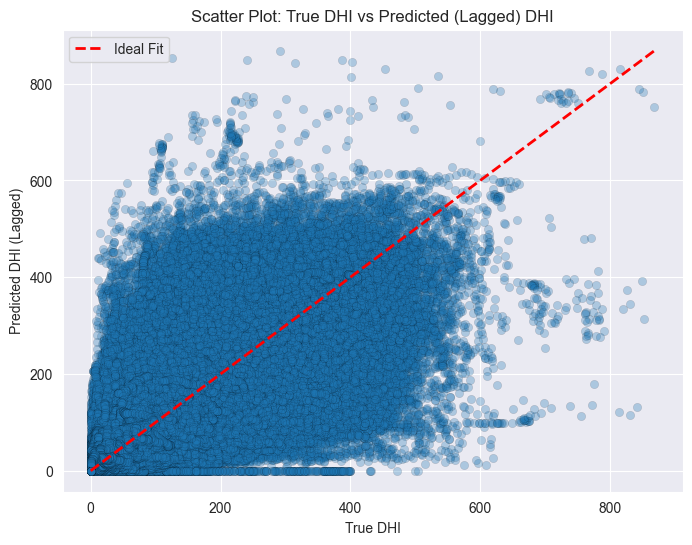

In [34]:
import random
random.seed(42)

# sample date from df
sample_date = random.choice(df.index).strftime('%Y-%m-%d')

# Plot residuals ignoring index (subset for visibility)
plt.figure(figsize=(14, 4))
# plot the first 5 days of residuals
plt.plot(df.loc[sample_date]['residual'])
plt.title("Residuals Over Time (First 3000 Minutes)")
plt.xlabel("Time Index")
plt.ylabel("Residual (DHI - DHI_lag_60)")
plt.grid(True)
plt.show()
plt.figure(figsize=(14, 4))
# plot the actual true and predicted values
plt.plot(df.loc[sample_date]['DHI'][:60*24*1], label='DHI', alpha=0.5)
plt.plot(df.loc[sample_date]['DHI_lag_60'][:60*24*1], label='DHI_lag_60', alpha=0.5)
plt.title("Residuals Over Time (First 3000 Minutes)")
plt.xlabel("Time Index")
plt.ylabel("Residual (DHI - DHI_lag_60)")
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(df['residual'], bins=100, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Q-Q plot for residuals
plt.figure(figsize=(6, 6))
sm.qqplot(df['residual'].dropna(), line='s', ax=plt.gca())
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual DHI
plt.figure(figsize=(8, 6))
plt.scatter(df['DHI'], df['DHI_lag_60'], alpha=0.3, edgecolor='k', linewidth=0.2)
plt.title("Scatter Plot: True DHI vs Predicted (Lagged) DHI")
plt.xlabel("True DHI")
plt.ylabel("Predicted DHI (Lagged)")
plt.grid(True)
plt.plot([df['DHI'].min(), df['DHI'].max()],
         [df['DHI'].min(), df['DHI'].max()],
         color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.legend()
plt.show()

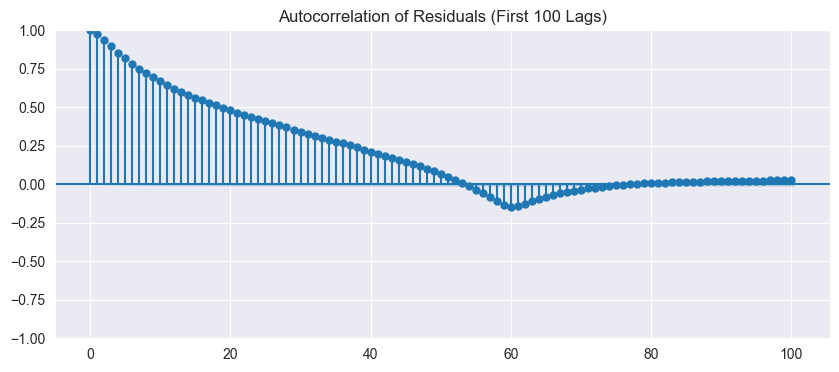

In [33]:
# Autocorrelation plot
plt.figure(figsize=(10, 4))
plot_acf(df['residual'].dropna(), lags=100, ax=plt.gca())
plt.title("Autocorrelation of Residuals (First 100 Lags)")
plt.grid(True)
plt.show()

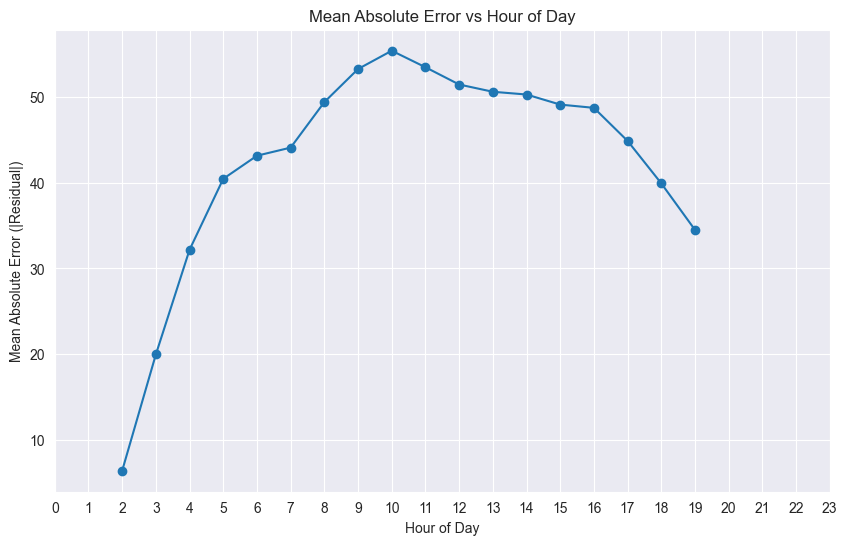

In [39]:
import numpy as np

df['hour'] = df.index.hour
df['abs_residual'] = np.abs(df['residual'])

# Group by hour and compute mean absolute residual
hourly_error = df.groupby('hour')['abs_residual'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hourly_error.index, hourly_error.values, marker='o')
plt.title("Mean Absolute Error vs Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error (|Residual|)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()